In [2]:
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 2.1 MB/s eta 0:00:00 0:00:01


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy import stats
import folium
from folium.plugins import HeatMap
import pickle
import json

%matplotlib inline

In [9]:
# Load the data
with open('state_genre_rankings.pkl', 'rb') as f:
    genre_rankings = pickle.load(f)

fema_data = pd.read_csv('../Weather/fema_disaster_declarations_processed.csv')
fema_data['declarationDate'] = pd.to_datetime(fema_data['declarationDate'])

# 1. Temporal Analysis
def temporal_analysis(fema_data, genre_rankings):
    # Yearly trend of disasters
    yearly_disasters = fema_data.groupby(fema_data['declarationDate'].dt.year).size()
    
    plt.figure(figsize=(12, 6))
    yearly_disasters.plot(kind='line')
    plt.title('Yearly Trend of Disasters')
    plt.xlabel('Year')
    plt.ylabel('Number of Disasters')
    plt.savefig('yearly_disaster_trend.png')
    plt.close()
    
    # Genre evolution over time
    genre_evolution = {}
    for year in range(fema_data['declarationDate'].dt.year.min(), fema_data['declarationDate'].dt.year.max() + 1):
        year_genres = []
        for state, genres in genre_rankings.items():
            state_data = fema_data[(fema_data['state'] == state) & (fema_data['declarationDate'].dt.year == year)]
            if not state_data.empty:
                year_genres.extend(genres.keys())
        genre_evolution[year] = Counter(year_genres)
    
    top_genres = [genre for genre, _ in Counter([g for genres in genre_evolution.values() for g in genres]).most_common(5)]
    
    genre_trend = pd.DataFrame({year: {genre: count for genre, count in year_genres.items() if genre in top_genres} 
                                for year, year_genres in genre_evolution.items()})
    
    plt.figure(figsize=(12, 6))
    genre_trend.plot(kind='line')
    plt.title('Evolution of Top 5 Genres Over Time')
    plt.xlabel('Year')
    plt.ylabel('Genre Frequency')
    plt.legend(title='Genre')
    # plt.savefig('genre_evolution.png')
    plt.close()

# 2. Geographical Analysis
def geographical_analysis(fema_data, genre_rankings):
    # Disaster frequency by state
    state_disaster_freq = fema_data['state'].value_counts()
    
    # Create a US map
    m = folium.Map(location=[48, -102], zoom_start=3)
    
    # Add disaster frequency heatmap
    heat_data = [[fema_data[fema_data['state'] == state]['latitude'].mean(),
                  fema_data[fema_data['state'] == state]['longitude'].mean(),
                  freq] for state, freq in state_disaster_freq.items()]
    HeatMap(heat_data).add_to(m)
    
    m.save('disaster_heatmap.html')
    
    # Top genre by state
    top_genres = {state: genres.most_common(1)[0][0] for state, genres in genre_rankings.items()}
    
    plt.figure(figsize=(15, 10))
    sns.barplot(x=list(top_genres.keys()), y=list(top_genres.values()))
    plt.title('Top Genre by State')
    plt.xlabel('State')
    plt.ylabel('Genre')
    plt.xticks(rotation=90)
    plt.tight_layout()
    # plt.savefig('top_genre_by_state.png')
    plt.close()

# 3. Disaster Type Correlation
def disaster_type_correlation(fema_data, genre_rankings):
    disaster_types = fema_data['incidentType'].unique()
    genres = list(set([genre for genres in genre_rankings.values() for genre in genres]))
    
    correlation_matrix = pd.DataFrame(index=disaster_types, columns=genres)
    
    for disaster in disaster_types:
        disaster_states = fema_data[fema_data['incidentType'] == disaster]['state'].unique()
        for genre in genres:
            genre_freq = sum([genres[genre] for state, genres in genre_rankings.items() if state in disaster_states])
            correlation_matrix.loc[disaster, genre] = genre_freq
    
    plt.figure(figsize=(20, 15))
    sns.heatmap(correlation_matrix, annot=False, cmap='YlOrRd')
    plt.title('Correlation between Disaster Types and Music Genres')
    plt.tight_layout()
    plt.savefig('disaster_genre_correlation.png')
    plt.close()

# 4. Genre Diversity Analysis
def genre_diversity_analysis(genre_rankings):
    def calculate_diversity(genres):
        total = sum(genres.values())
        proportions = [count / total for count in genres.values()]
        return -sum(p * np.log(p) for p in proportions if p > 0)
    
    diversity_scores = {state: calculate_diversity(genres) for state, genres in genre_rankings.items()}
    
    plt.figure(figsize=(15, 8))
    sns.barplot(x=list(diversity_scores.keys()), y=list(diversity_scores.values()))
    plt.title('Genre Diversity by State')
    plt.xlabel('State')
    plt.ylabel('Diversity Score (Higher is more diverse)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('state_genre_diversity.png')
    plt.close()
    
    # Correlation with disaster frequency
    disaster_frequency = fema_data['state'].value_counts()
    diversity_df = pd.DataFrame.from_dict(diversity_scores, orient='index', columns=['Diversity'])
    diversity_df['DisasterFrequency'] = disaster_frequency
    
    correlation, p_value = stats.pearsonr(diversity_df['Diversity'], diversity_df['DisasterFrequency'])
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=diversity_df, x='DisasterFrequency', y='Diversity')
    plt.title(f'Genre Diversity vs Disaster Frequency (Correlation: {correlation:.2f}, p-value: {p_value:.4f})')
    plt.xlabel('Number of Disasters')
    plt.ylabel('Genre Diversity Score')
    plt.tight_layout()
    plt.savefig('diversity_vs_disaster_frequency.png')
    plt.close()

# 5. Mood Analysis
def mood_analysis(genre_rankings, fema_data):
    # This is a simplified mood categorization. In a real analysis, you'd want a more comprehensive and validated categorization.
    mood_categories = {
        'upbeat': ['pop', 'dance', 'electronic', 'hip-hop', 'rap'],
        'relaxed': ['acoustic', 'folk', 'indie', 'ambient'],
        'energetic': ['rock', 'metal', 'punk', 'alternative'],
        'melancholic': ['blues', 'jazz', 'soul', 'r&b']
    }
    
    def categorize_mood(genre):
        for mood, genres in mood_categories.items():
            if any(g in genre.lower() for g in genres):
                return mood
        return 'other'
    
    state_moods = {}
    for state, genres in genre_rankings.items():
        mood_counts = Counter(categorize_mood(genre) for genre in genres.keys())
        total = sum(mood_counts.values())
        state_moods[state] = {mood: count / total for mood, count in mood_counts.items()}
    
    mood_df = pd.DataFrame(state_moods).T
    
    plt.figure(figsize=(15, 8))
    mood_df.plot(kind='bar', stacked=True)
    plt.title('Mood Distribution of Music by State')
    plt.xlabel('State')
    plt.ylabel('Proportion of Moods')
    plt.legend(title='Mood')
    plt.tight_layout()
    plt.savefig('state_mood_distribution.png')
    plt.close()
    
    # Correlation with disaster frequency
    disaster_freq = fema_data['state'].value_counts()
    mood_df['DisasterFrequency'] = disaster_freq
    
    for mood in mood_categories.keys():
        correlation, p_value = stats.pearsonr(mood_df[mood], mood_df['DisasterFrequency'])
        print(f"Correlation between {mood} music and disaster frequency: {correlation:.2f} (p-value: {p_value:.4f})")

In [8]:
# Run all analyses
print("Running temporal analysis...")
temporal_analysis(fema_data, genre_rankings)

Running temporal analysis...


<Figure size 1200x600 with 0 Axes>

In [10]:
print("Running geographical analysis...")
geographical_analysis(fema_data, genre_rankings)

Running geographical analysis...


KeyError: 'latitude'

Running disaster type correlation analysis...


TypeError: Image data of dtype object cannot be converted to float

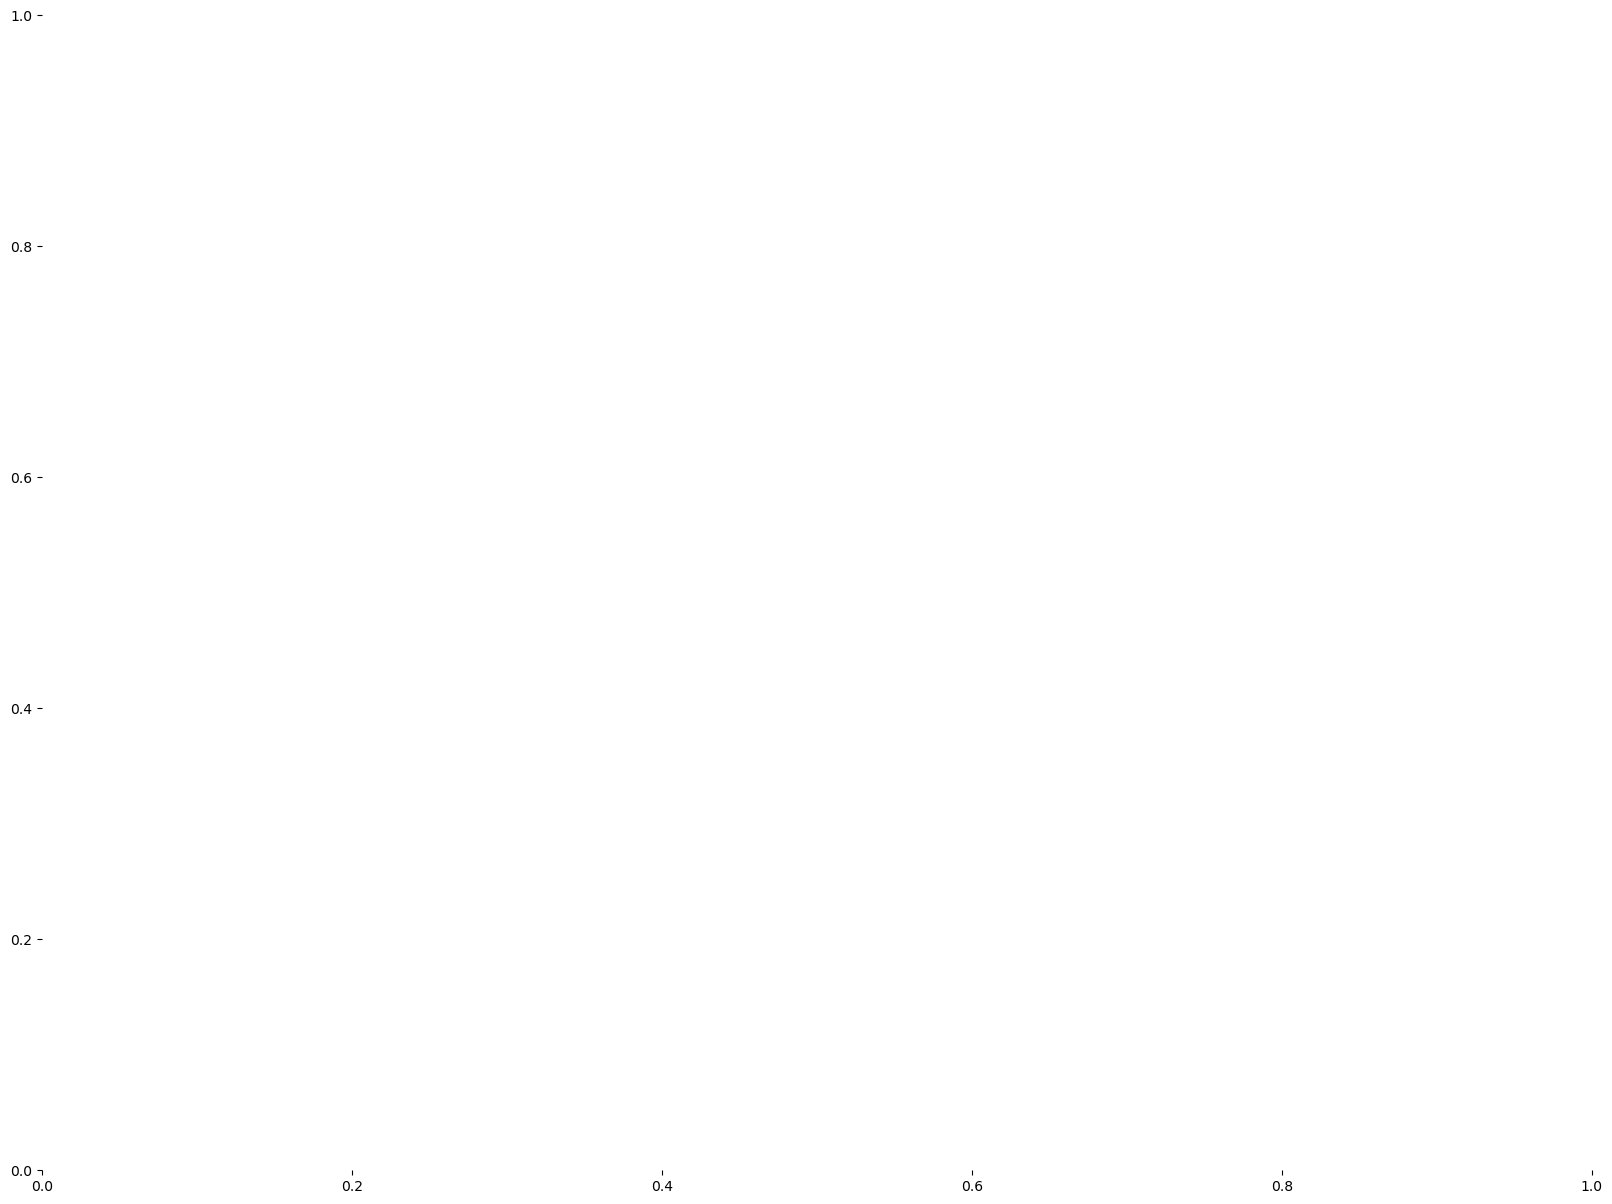

In [11]:

print("Running disaster type correlation analysis...")
disaster_type_correlation(fema_data, genre_rankings)

In [12]:
print("Running genre diversity analysis...")
genre_diversity_analysis(genre_rankings)

Running genre diversity analysis...


/Users/robertoreis/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


In [13]:
print("Running mood analysis...")
mood_analysis(genre_rankings, fema_data)

Running mood analysis...


ValueError: array must not contain infs or NaNs

<Figure size 1500x800 with 0 Axes>

In [ ]:


print("All analyses complete. Check the generated PNG files for visualizations.")